In [1]:
# This notebook creates spectrogram images from a directory of sound files in .wav format.
# The code is optimized to be processed in parallel on multi-core machines.

In [2]:
# Spectogram generation library
# https://librosa.org/doc/latest/index.html
import sys
!conda install --yes --prefix {sys.prefix} librosa


Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
 - apple
Platform: osx-arm64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 23.7.1
    latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /Users/adityakrishna/miniforge3/envs/nabat_ml

  added / updated specs:
    - librosa


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.1.2              |       h53f4e23_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following packages will be UPDATED:

  ca-certificates                       2023.5.7-hf0a4a13_0 --> 2023.7.22-hf0a4a13_0 
  certifi                             2023.5.7-pyhd8ed1ab_0 --> 20

In [3]:
# imports

# With the exception of the librosa library installed above, all of these modules are 
# either included in the code base or provided by default on Amazon Sagemaker. 

import gc
import glob
import io
import multiprocessing as mp
import os
import os.path
import pickle
import pprint
import random
import time
from multiprocessing import Pool
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
from db import NABat_DB
from IPython.display import Image
from PIL import Image
from spectrogram import Spectrogram


In [7]:
import db_handler

In [4]:
# Test we have a valid database and enumerate the species represented.
db = NABat_DB()
species = db.query(' select * from species;')
pprint.pprint(species)
db.conn.close()


[Row(id=1, species_code='ANPA', common_name='Pallid bat', min_frequency=27000, max_frequency=51000, available=1),
 Row(id=2, species_code='CHME', common_name='Mexican long-tongued bat', min_frequency=4999, max_frequency=99999, available=1),
 Row(id=3, species_code='CORA', common_name="Rafinesque's big-eared bat", min_frequency=4999, max_frequency=99999, available=1),
 Row(id=4, species_code='COTO', common_name="Townsend's big-eared bat", min_frequency=22000, max_frequency=41000, available=1),
 Row(id=5, species_code='EPFU', common_name='Big brown bat', min_frequency=25000, max_frequency=52000, available=1),
 Row(id=6, species_code='EUMA', common_name='Spotted bat', min_frequency=10000, max_frequency=17000, available=1),
 Row(id=7, species_code='EUFL', common_name='Florida bonneted bat', min_frequency=10000, max_frequency=25000, available=1),
 Row(id=8, species_code='EUPE', common_name='Greater mastiff bat', min_frequency=10000, max_frequency=19000, available=1),
 Row(id=9, species_code

In [5]:
# Point to a directory containing .wav files organized by species code. 
# Example "../v1.1.0/data/wav/ANPA/p163_g89522_f28390444.wav"
directory = '../Downloads/data/wav'

Median files per class:  165.0


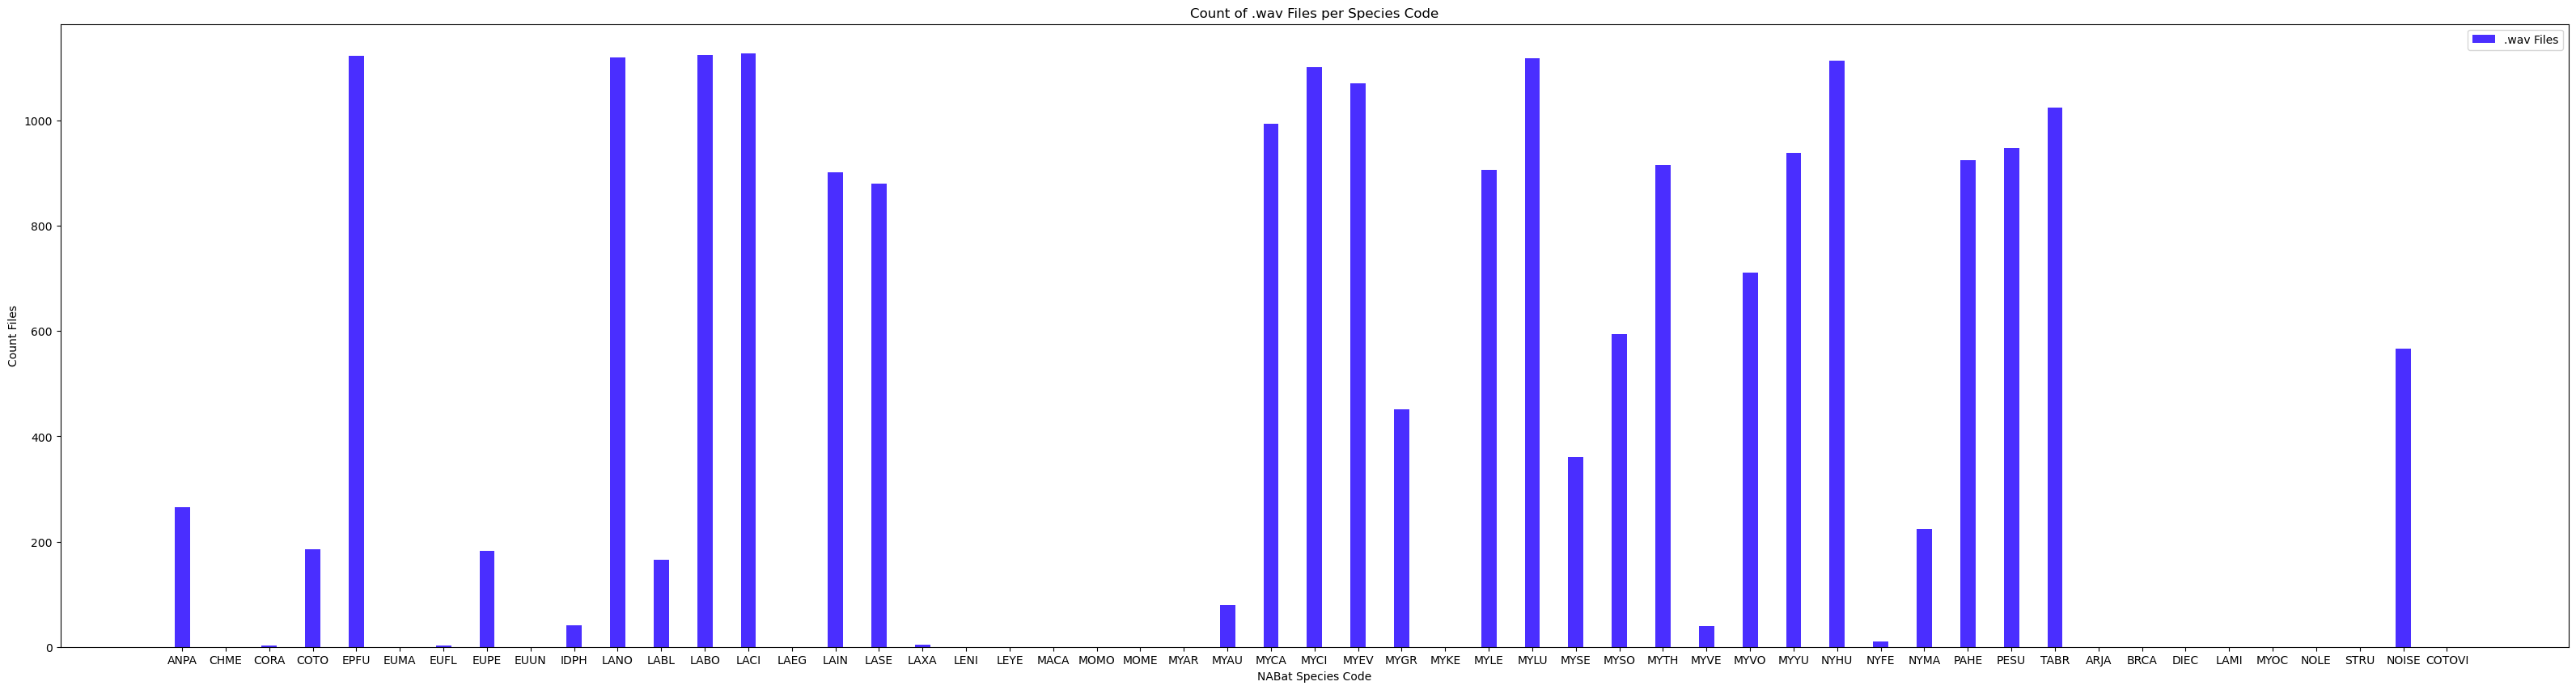

In [6]:
# Optional step.
# Create a plot visualizing our sample size of input data.

plt.close(fig='all')
class_names = []
wav_count = []
for s in species:
    class_names.append(s[1])
    wav_count.append(len(glob.glob('{}/{}/*.wav'.format(directory,s[1]), recursive=True)))

figure = plt.figure(figsize=(40, 10))

labels = class_names
count = np.array(wav_count)
print('Median files per class: ', np.median(count)//1)

width = 0.35 # the width of the bars: can also be len(x) sequence

plt.bar(labels, count, width, color="#4a2eff", label='.wav Files')

plt.ylabel('Count Files')
plt.xlabel('NABat Species Code')

plt.title('Count of .wav Files per Species Code')
plt.legend()
plt.show()


In [10]:
# Use as many threads as we can, leaving one available to keep notebook responsive.
thread_count = (mp.cpu_count() - 1)
print('using {} threads'.format(thread_count))
 
# Gather wav files.
files = glob.glob('{}/**/*.wav'.format(directory), recursive=True)
progress = int(len(files) * 0.01)

using 7 threads


In [11]:
# Start the creation process in parallel and report progress.
for i in range(0,len(files),progress):
    with Pool(thread_count) as p:
        p.map(db_handler.process_file, files[i:i+progress])
        gc.collect()
        print('{}%'.format(int(i/progress)))


0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
100%


In [ ]:
# Done!